# Training and analysis script for ViT Classifier of PIScO Plankton images
Version: 250611


In [33]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1"

import torch
import numpy as np
from datasets import load_dataset, DatasetDict, ClassLabel#, load_metric
from datasets import Dataset, Features, Image as ImageFeature, Value
from PIL import Image
import torchvision.transforms as transforms
from transformers import AutoImageProcessor
import torchvision.transforms.functional as F
from transformers import Trainer
import evaluate
from transformers import TrainingArguments

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict

import matplotlib.pyplot as plt
import random
from transformers import AutoImageProcessor, ViTForImageClassification

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

from torch.utils.data import DataLoader
from tqdm import tqdm

import pandas as pd


## Core Functions

In [2]:
def visualize_transformations(dataset, original_ds, num_samples=25, rows=5, cols=5):
    # Randomly sample indices
    total_samples = len(dataset)
    random_indices = random.sample(range(total_samples), min(num_samples, total_samples))
    
    # Create a figure
    fig = plt.figure(figsize=(20, 20))
    
    for idx, sample_idx in enumerate(random_indices):
        # Get original image and transformed version
        original = original_ds[sample_idx]
        transformed = dataset[sample_idx]
        
        label = original_ds.features['label'].names[original['label']]
        
        # Original image
        plt.subplot(rows, cols*2, idx*2 + 1)
        plt.imshow(original['image'])
        plt.title(f'Original\n{label}', fontsize=8)
        plt.axis('off')
        
        # Transformed image
        plt.subplot(rows, cols*2, idx*2 + 2)
        # Convert tensor to numpy and adjust for display
        transformed_img = transformed['pixel_values'].permute(1, 2, 0).numpy()
        transformed_img = (transformed_img * 0.5 + 0.5).clip(0, 1)  # Denormalize
        plt.imshow(transformed_img)
        plt.title('Transformed', fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_label_distribution(dataset, title="Label Distribution"):
    # Count labels
    label_counts = Counter(dataset['label'])
    
    # Convert to percentages
    total_samples = len(dataset)
    label_percentages = {dataset.features['label'].names[k]: (v/total_samples)*100 
                        for k, v in label_counts.items()}
    
    # Sort by frequency
    sorted_items = sorted(label_percentages.items(), key=lambda x: x[1], reverse=True)
    labels, values = zip(*sorted_items)
    
    # Create figure with sufficient height for labels
    plt.figure(figsize=(15, 8))
    
    # Create bar plot
    bars = plt.bar(labels, values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Percentage of Dataset (%)')
    plt.title(title)
    
    # Add percentage values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    # Print statistics
    print(f"\nDataset Statistics:")
    print(f"Total samples: {total_samples}")
    print(f"\nClass distribution:")
    for label, percentage in sorted_items:
        count = int(percentage * total_samples / 100)
        print(f"{label}: {count} samples ({percentage:.1f}%)")
    
    # Calculate imbalance ratio (majority:minority)
    max_samples = max(label_counts.values())
    min_samples = min(label_counts.values())
    imbalance_ratio = max_samples / min_samples
    print(f"\nImbalance ratio (majority:minority): {imbalance_ratio:.1f}:1")
    
    plt.tight_layout()
    plt.show()

def preprocess_dataset(dataset, min_samples=10, max_samples=1000, merge_classes=None, exclude_classes=None):
    """
    Preprocess dataset with class merging, exclusion, and sample count constraints.
    """
    # Group samples by label
    label_groups = defaultdict(list)
    labels = dataset.features['label'].names
    
    for idx, item in enumerate(dataset):
        current_label = labels[item['label']]
        label_groups[current_label].append(idx)
    
    # Create mapping for merged classes
    merged_to_new = {}
    if merge_classes:
        for new_class, classes_to_merge in merge_classes.items():
            for old_class in classes_to_merge:
                merged_to_new[old_class] = new_class
    
    # Remove excluded classes
    if exclude_classes:
        for class_name in exclude_classes:
            if class_name in label_groups:
                print(f"Excluding class: {class_name}")
                del label_groups[class_name]
    
    # Merge classes if specified
    if merge_classes:
        for new_class, classes_to_merge in merge_classes.items():
            # Skip if new class is in excluded classes
            if exclude_classes and new_class in exclude_classes:
                continue
            # Collect all indices for classes to merge
            merged_indices = []
            for class_name in classes_to_merge:
                if class_name in label_groups:
                    merged_indices.extend(label_groups[class_name])
                    del label_groups[class_name]
            # Add merged class if it has enough samples
            if len(merged_indices) >= min_samples:
                label_groups[new_class] = merged_indices
    
    # Filter and sample classes
    valid_indices = []
    new_label_mapping = {}
    new_label_names = []
    current_label_id = 0
    
    for class_name, indices in label_groups.items():
        if len(indices) < min_samples:
            print(f"Dropping class {class_name}: only {len(indices)} samples (min: {min_samples})")
            continue
        
        if len(indices) > max_samples:
            print(f"Sampling {max_samples} from {len(indices)} samples for class {class_name}")
            indices = random.sample(indices, max_samples)
        
        valid_indices.extend(indices)
        new_label_mapping[class_name] = current_label_id
        new_label_names.append(class_name)
        current_label_id += 1
    
    def remap_labels(example):
        old_label = labels[example['label']]
        # Check if this label should be merged
        if old_label in merged_to_new:
            old_label = merged_to_new[old_label]
        new_label = new_label_mapping[old_label]
        return {'image': example['image'], 'label': new_label}
    
    # Select valid indices and remap labels
    filtered_dataset = dataset.select(valid_indices).map(remap_labels)
    
    # Update label names in dataset features
    filtered_dataset = filtered_dataset.cast_column("label", 
        ClassLabel(names=new_label_names))
    
    return filtered_dataset

In [3]:
def resize_to_larger_edge(image, target_size):
    # Get the original dimensions of the image
    original_width, original_height = image.size
    
    # Determine which dimension is larger
    larger_edge = max(original_width, original_height)
    
    # Compute the scale factor to resize the larger edge to the target size
    scale_factor = target_size / larger_edge
    
    # Compute new dimensions
    new_width = int(original_width * scale_factor)
    new_height = int(original_height * scale_factor)
    
    try:
    # Resize the image
        resized_image = F.resize(image, (new_height, new_width))
    except(ValueError):
        #print(image.size,new_height,new_width)
        logging.info(f"Skipping: {image}: image size: {image.size}, new height: {new_height}, new width: {new_width}")
        return None        
    return resized_image

def custom_image_processor(image, target_size=(224, 224), padding_color=255):
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Step 0: Remove scale bar by cropping the bottom 50 pixels
    width, height = image.size
    image = image.crop((0, 0, width, height - 50))  # Crop out the scale bar area
    
    # Step 1: Resize the image
    resized_image = resize_to_larger_edge(image,224)

    if resized_image is None:  # Skip processing if resizing failed
        #print(f"Skipping image due to resize failure: {image.size}")
        return None  # This allows to filter out bad images later

    #Step 2: Calculate padding
    new_width, new_height = resized_image.size
    padding_left = (target_size[0] - new_width) // 2
    padding_right = target_size[0] - new_width - padding_left
    padding_top = (target_size[1] - new_height) // 2
    padding_bottom = target_size[1] - new_height - padding_top

    # Step 3: Apply padding
    padding = (padding_left, padding_top, padding_right, padding_bottom)
    pad_transform = transforms.Pad(padding, fill=padding_color)
    padded_image = pad_transform(resized_image)

    # Step 4: Apply other transformations
    transform_chain = transforms.Compose([
        transforms.RandomRotation(degrees=180,fill=255),
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
    ])
    
    # Apply the transformations
    return transform_chain(padded_image)

# Example function to process a batch
def process_batch(example_batch):
    # Process each image in the batch
    processed_images = [
        custom_image_processor(img) for img in example_batch['image']
        if custom_image_processor(img) is not None
        ]
    
    # Convert to a batch tensor
    inputs = torch.stack(processed_images)
    
    # Include labels (assuming they are present and you want to keep them)
    return {'pixel_values': inputs, 'label': example_batch['label']}


### Loading and analysis of the  datasets from Ecotaxa export of validated/annotated images (General export with folders for categories).
Configuring for balanced training. Here we can still tune a lot.

Generating train split: 9975 examples [00:00, 58310.08 examples/s]


Excluding class: othertocheck
Excluding class: sphere_othertocheck
Excluding class: multiple_other
Sampling 500 from 586 samples for class Acantharia
Sampling 500 from 544 samples for class Calanoida
Sampling 500 from 545 samples for class Chaetognatha
Sampling 500 from 811 samples for class Copepoda_Maxillopoda
Dropping class Echinodermata: only 2 samples (min: 5)
Dropping class Ophiuroidea: only 2 samples (min: 5)
Dropping class Spumellaria: only 1 samples (min: 5)
Dropping class Tunicata: only 1 samples (min: 5)
Sampling 500 from 722 samples for class artefact
Sampling 500 from 1176 samples for class bubble
Dropping class budding_Doliolida: only 2 samples (min: 5)
Sampling 500 from 504 samples for class detritus
Dropping class gelatinous: only 3 samples (min: 5)
Dropping class multiple_Copepoda: only 1 samples (min: 5)
Dropping class noise: only 3 samples (min: 5)
Dropping class solitaryblack-like: only 1 samples (min: 5)
Sampling 500 from 958 samples for class Appendicularia


Casting the dataset: 100%|██████████| 7603/7603 [00:00<00:00, 245918.95 examples/s]



Final dataset distribution:

Train Set Distribution:

Dataset Statistics:
Total samples: 4561

Class distribution:
Calanoida: 300 samples (6.6%)
artefact: 300 samples (6.6%)
Appendicularia: 300 samples (6.6%)
Acantharia: 300 samples (6.6%)
bubble: 300 samples (6.6%)
Chaetognatha: 300 samples (6.6%)
detritus: 300 samples (6.6%)
Copepoda_Maxillopoda: 300 samples (6.6%)
Noctiluca sp.: 291 samples (6.4%)
tuft: 274 samples (6.0%)
Cnidaria_Metazoa: 259 samples (5.7%)
puff: 247 samples (5.4%)
streak: 175 samples (3.8%)
Bacillariophyceae: 160 samples (3.5%)
Doliolida: 150 samples (3.3%)
Oithona: 132 samples (2.9%)
Thaliacea: 89 samples (2.0%)
Salpidae: 57 samples (1.2%)
Siphonophorae: 52 samples (1.1%)
tentacle_Cnidaria: 50 samples (1.1%)
house: 46 samples (1.0%)
dark_sphere: 42 samples (0.9%)
nurse: 35 samples (0.8%)
Ctenophora_Metazoa: 24 samples (0.5%)
Asteroidea larvae: 20 samples (0.4%)
solitaryblack: 13 samples (0.3%)
Rhizaria: 12 samples (0.3%)
part_Cnidaria: 8 samples (0.2%)
Crustacea

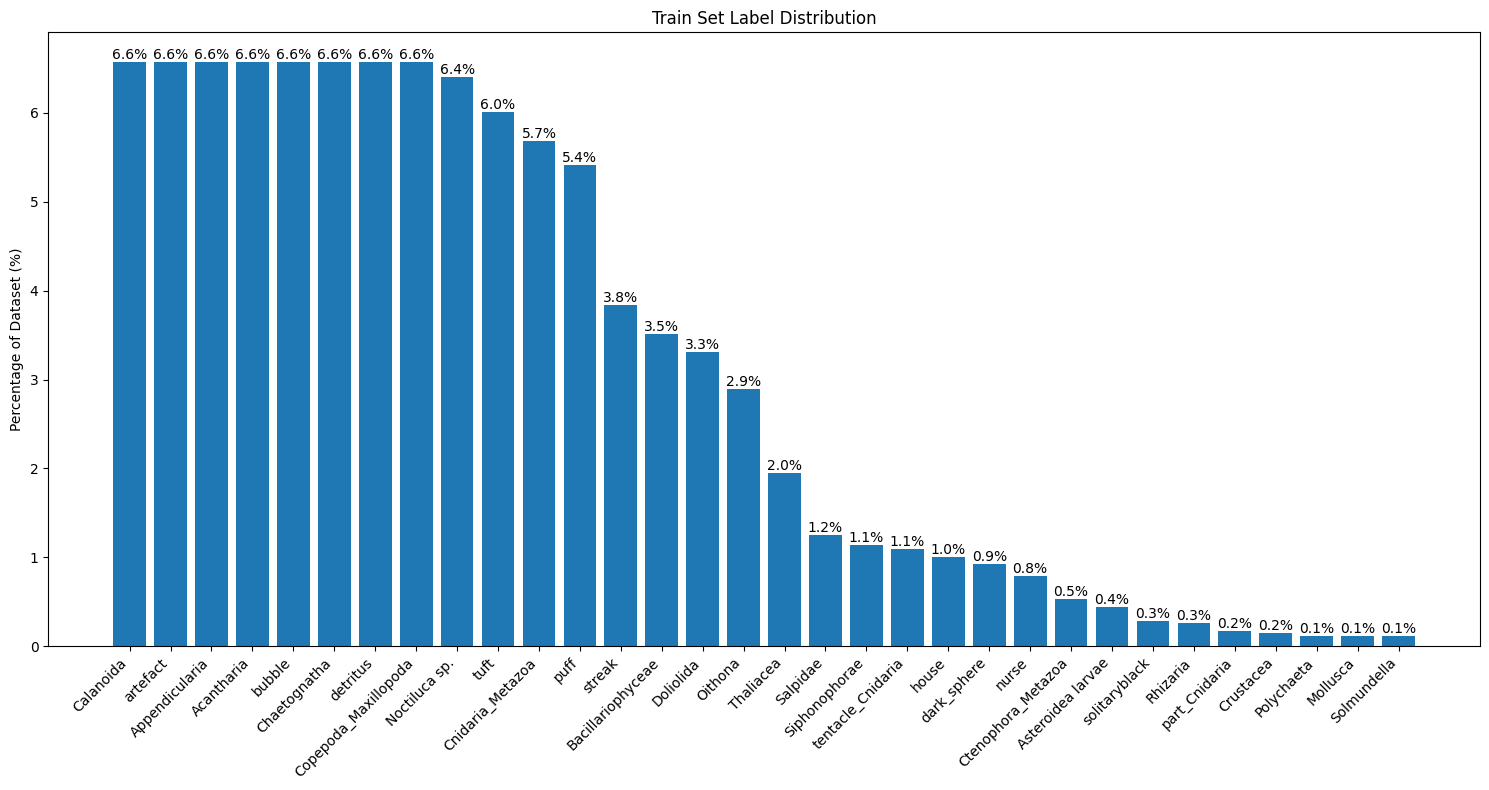


Validation Set Distribution:

Dataset Statistics:
Total samples: 1521

Class distribution:
Acantharia: 100 samples (6.6%)
Calanoida: 100 samples (6.6%)
Appendicularia: 100 samples (6.6%)
Copepoda_Maxillopoda: 100 samples (6.6%)
detritus: 100 samples (6.6%)
bubble: 100 samples (6.6%)
artefact: 100 samples (6.6%)
Chaetognatha: 100 samples (6.6%)
Noctiluca sp.: 98 samples (6.4%)
tuft: 92 samples (6.0%)
Cnidaria_Metazoa: 86 samples (5.7%)
puff: 83 samples (5.5%)
streak: 58 samples (3.8%)
Bacillariophyceae: 53 samples (3.5%)
Doliolida: 51 samples (3.4%)
Oithona: 44 samples (2.9%)
Thaliacea: 30 samples (2.0%)
Salpidae: 19 samples (1.2%)
Siphonophorae: 17 samples (1.1%)
tentacle_Cnidaria: 17 samples (1.1%)
house: 16 samples (1.1%)
dark_sphere: 14 samples (0.9%)
nurse: 12 samples (0.8%)
Ctenophora_Metazoa: 8 samples (0.5%)
Asteroidea larvae: 7 samples (0.5%)
solitaryblack: 5 samples (0.3%)
Rhizaria: 4 samples (0.3%)
Crustacea: 2 samples (0.1%)
part_Cnidaria: 2 samples (0.1%)
Polychaeta: 1 sam

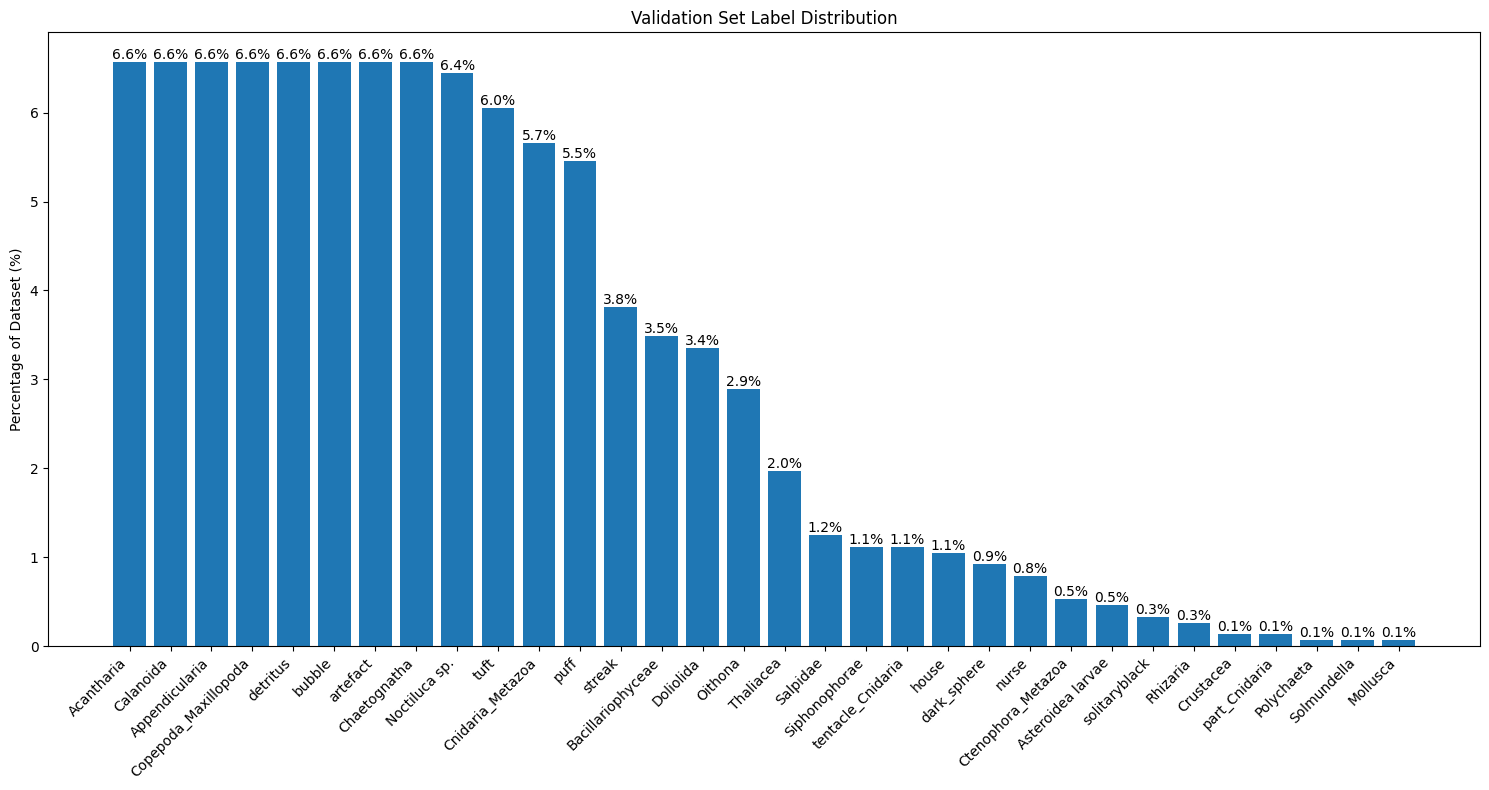


Test Set Distribution:

Dataset Statistics:
Total samples: 1521

Class distribution:
Calanoida: 100 samples (6.6%)
detritus: 100 samples (6.6%)
artefact: 100 samples (6.6%)
Appendicularia: 100 samples (6.6%)
Chaetognatha: 100 samples (6.6%)
bubble: 100 samples (6.6%)
Acantharia: 100 samples (6.6%)
Copepoda_Maxillopoda: 100 samples (6.6%)
Noctiluca sp.: 98 samples (6.4%)
tuft: 92 samples (6.0%)
Cnidaria_Metazoa: 86 samples (5.7%)
puff: 82 samples (5.4%)
streak: 58 samples (3.8%)
Bacillariophyceae: 53 samples (3.5%)
Doliolida: 51 samples (3.4%)
Oithona: 44 samples (2.9%)
Thaliacea: 30 samples (2.0%)
Salpidae: 19 samples (1.2%)
Siphonophorae: 17 samples (1.1%)
tentacle_Cnidaria: 17 samples (1.1%)
house: 16 samples (1.1%)
dark_sphere: 14 samples (0.9%)
nurse: 12 samples (0.8%)
Ctenophora_Metazoa: 8 samples (0.5%)
Asteroidea larvae: 7 samples (0.5%)
solitaryblack: 5 samples (0.3%)
Rhizaria: 4 samples (0.3%)
Mollusca: 2 samples (0.1%)
Crustacea: 2 samples (0.1%)
part_Cnidaria: 2 samples (0.

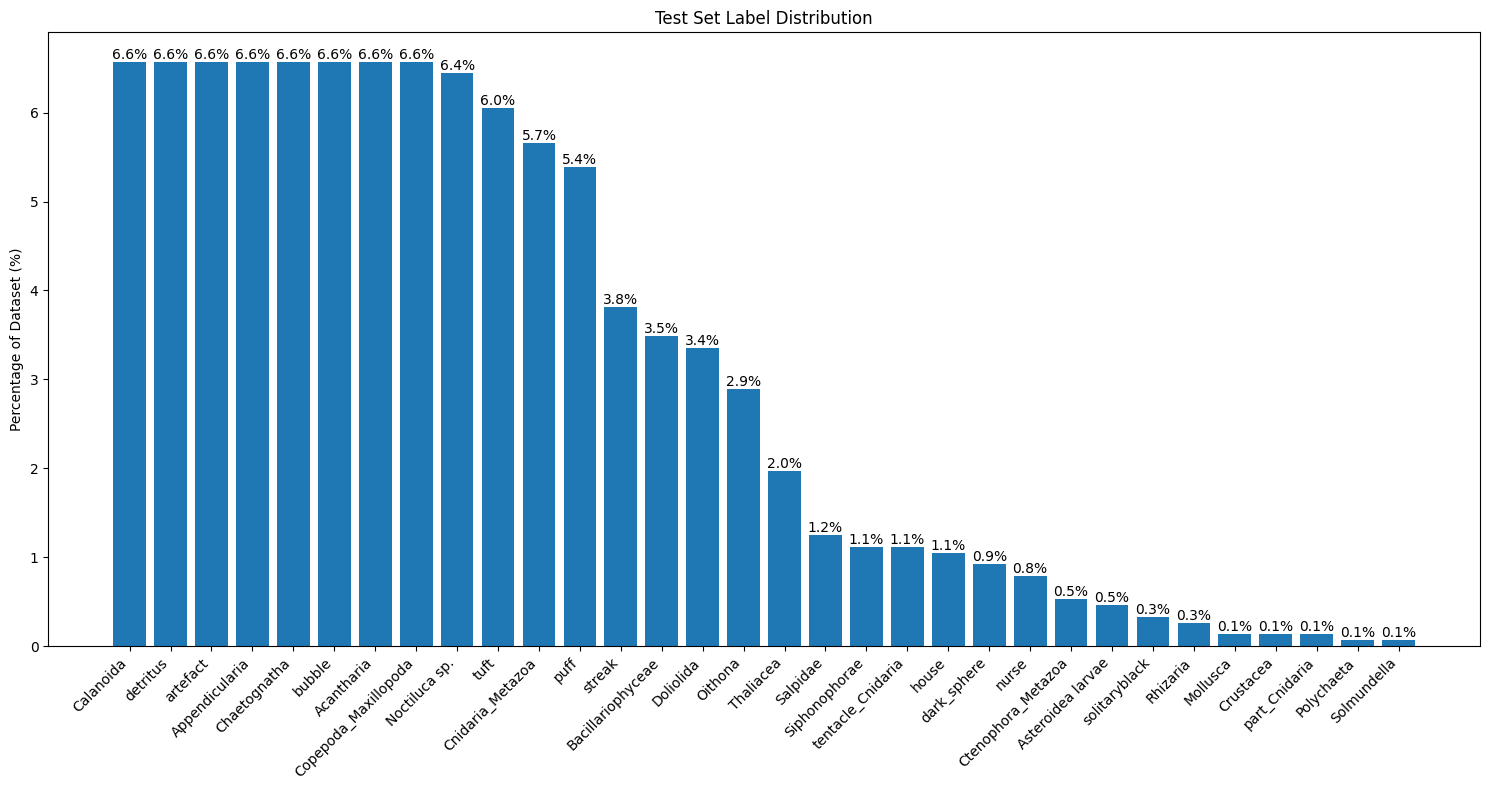

In [4]:
root_dir = '/home/veit/Downloads/export__TSV_17108_20250610_1155'
# First load the full dataset
full_ds = load_dataset("imagefolder", data_dir=root_dir)

# Classes to merge
merge_classes = {
    'Appendicularia': ['Appendicularia', 'body_Appendicularia'],
    #'detritus': ['detritus_small', 'detritus_large', 'marine_snow']
}

# Classes to exclude
exclude_classes = ['othertocheck', 'sphere_othertocheck', 'multiple_other']  

# Process the full dataset before splitting
processed_full_ds = preprocess_dataset(
    full_ds['train'],
    min_samples=5,      # Minimum 5 samples per class
    max_samples=500,    # Maximum 500 samples per class
    merge_classes=merge_classes,
    exclude_classes=exclude_classes
)

# Then split into train/validation/test
train_val_test = processed_full_ds.train_test_split(
    test_size=0.2,
    seed=42,
    shuffle=True,
    stratify_by_column="label"
)

train_val = train_val_test['train'].train_test_split(
    test_size=0.25,
    seed=42,
    shuffle=True,
    stratify_by_column="label"
)

ds = DatasetDict({
    'train': train_val['train'],
    'validation': train_val['test'],
    'test': train_val_test['test']
})

# Verify the distribution
print("\nFinal dataset distribution:")
for split in ['train', 'validation', 'test']:
    print(f"\n{split.capitalize()} Set Distribution:")
    analyze_label_distribution(ds[split], f"{split.capitalize()} Set Label Distribution")

labels = ds['train'].features['label'].names

# Apply the custom image processor to the dataset
prepared_ds = ds.with_transform(process_batch)

In [5]:
# Dataset structure and sample counts

ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4561
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1521
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1521
    })
})

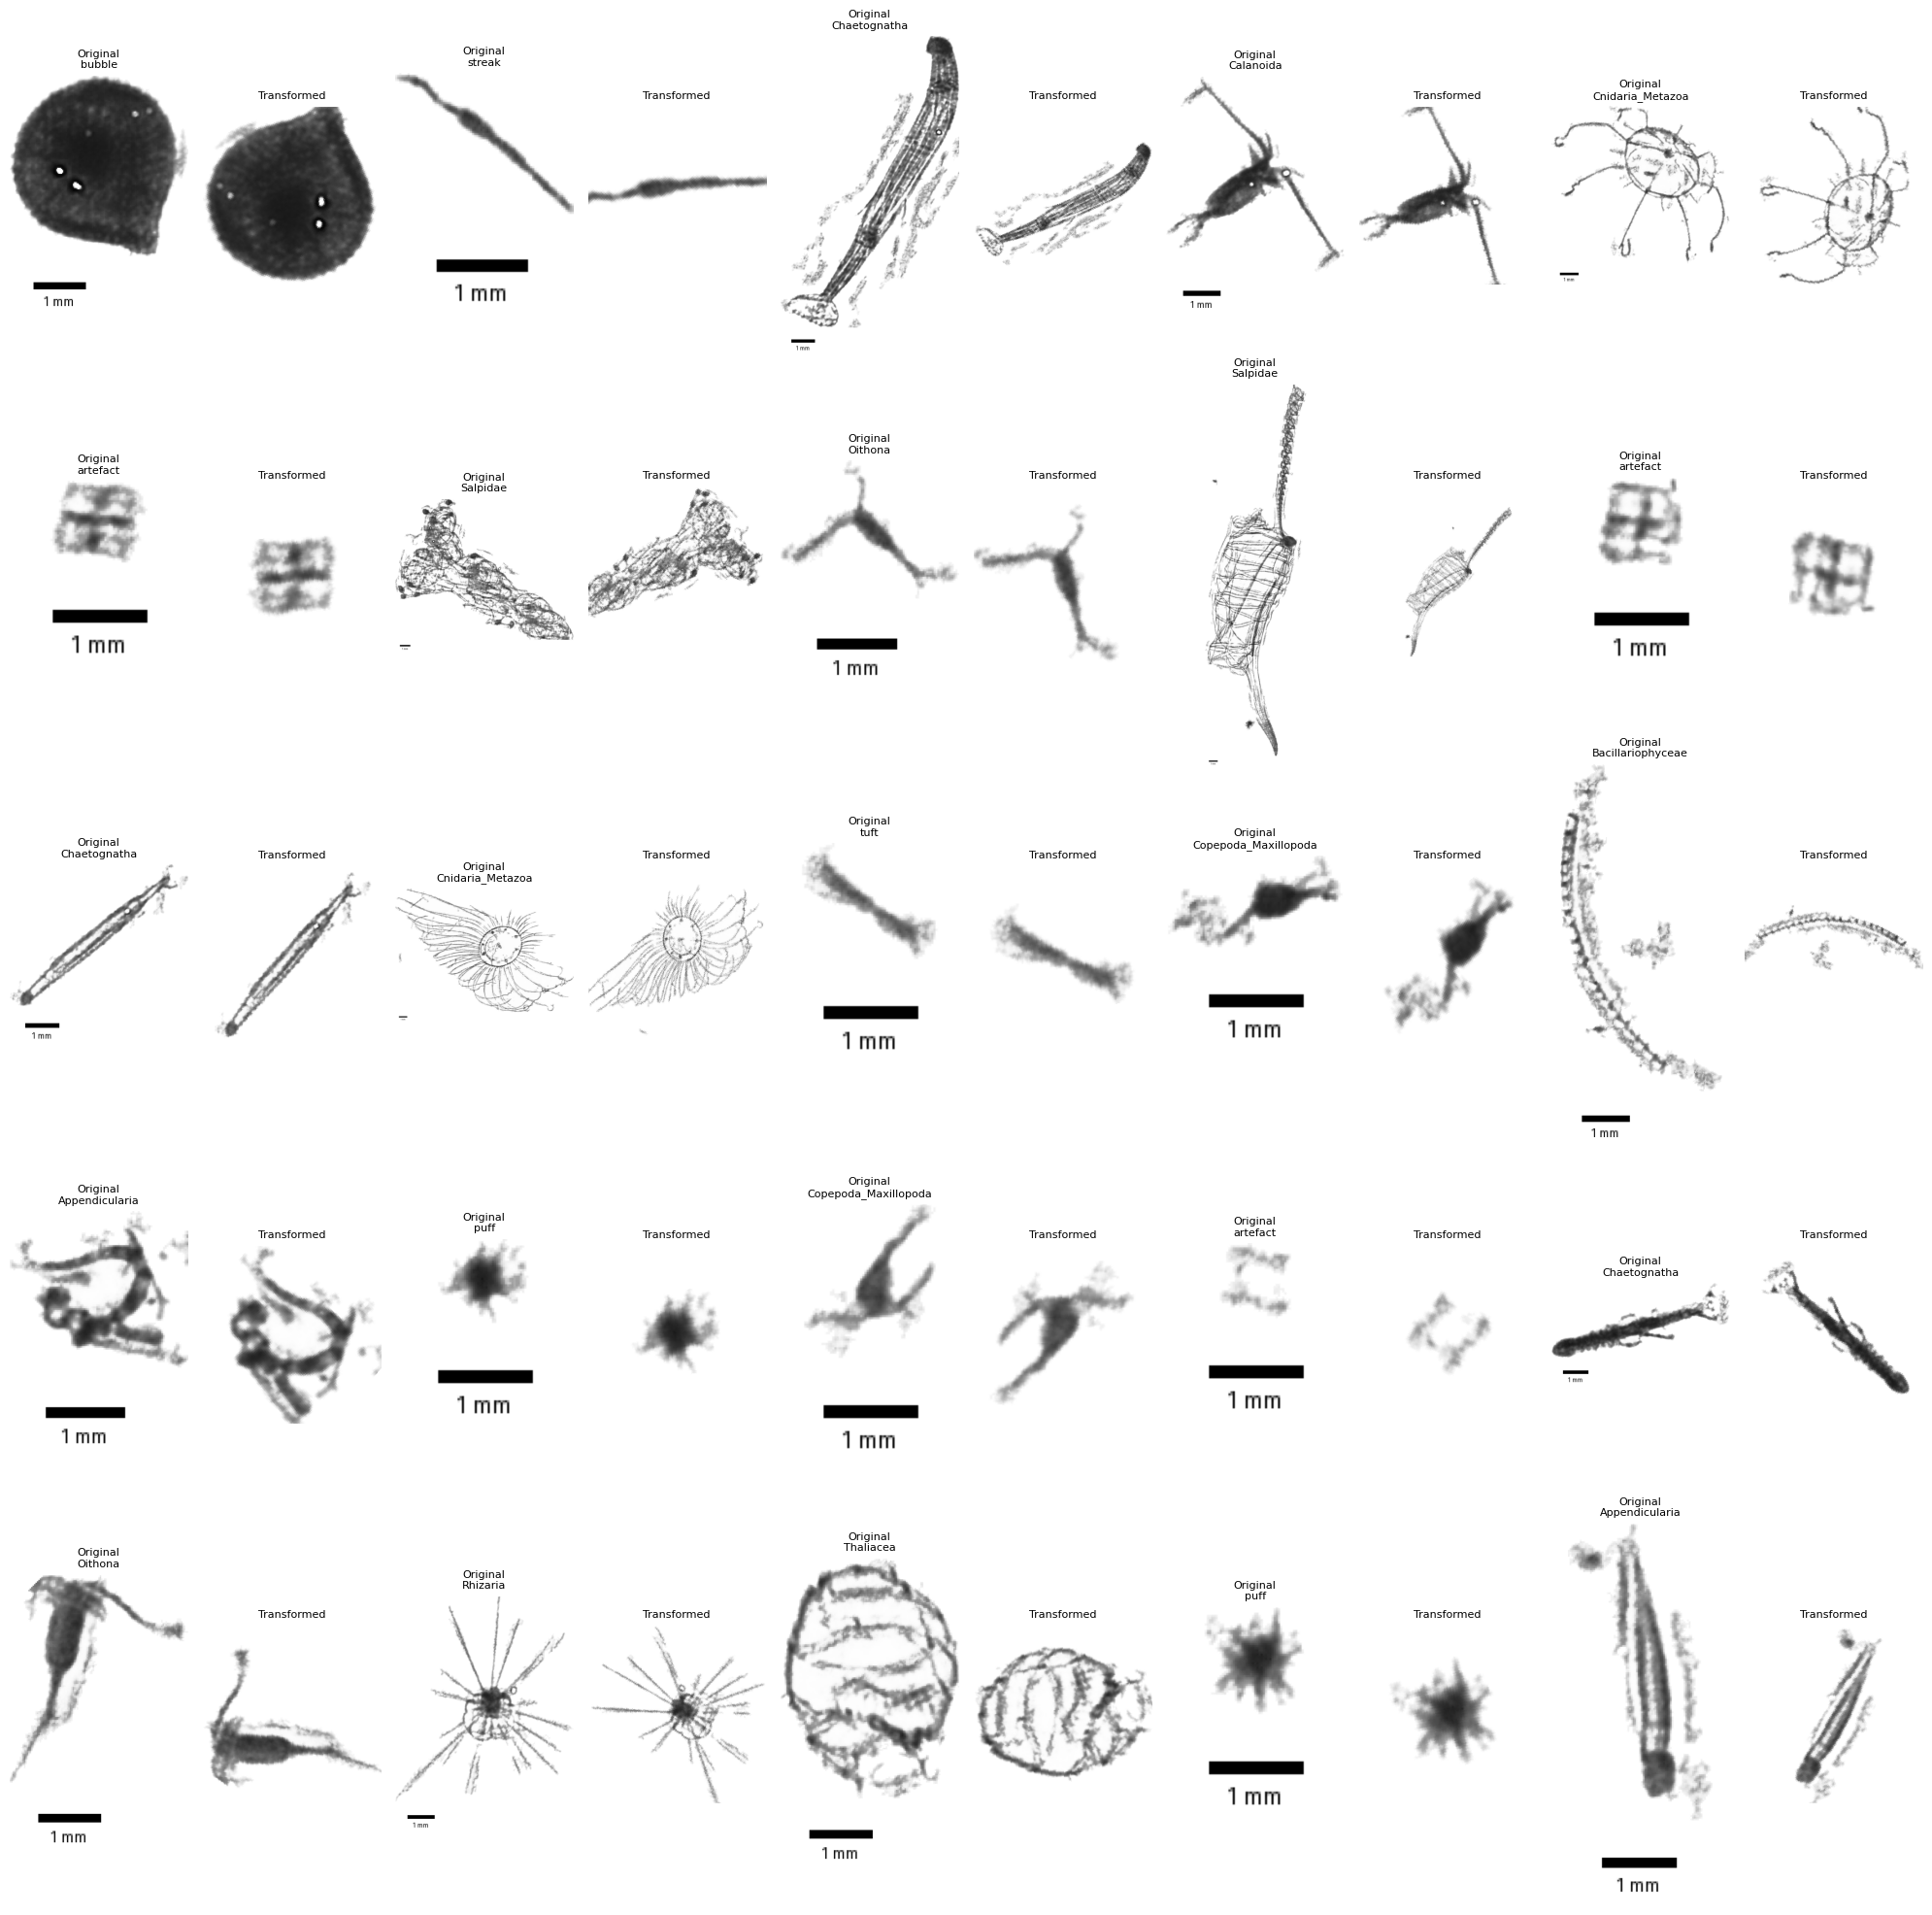

In [6]:
# Show the effect of the transformations that are applied to each image. Images will be shown in pairs: original and transformed.
# This is how the ViT will receive the images... sort of at least.

visualize_transformations(prepared_ds['train'], ds['train'])

## Setup of the ViT 

In [7]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
#model_name_or_path = '/home/plankton/PISCO_Classification/ViT_custom_size_sensitive/best_model/'

root_dir = "/home/veit/PIScO_dev/ViT_custom_size_sensitive/"  # Path where all config files and checkpoints will be saved

In [8]:
#processor = AutoImageProcessor.from_pretrained(model_name_or_path, use_fast=True)
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

metric = evaluate.load("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

training_args = TrainingArguments(
  output_dir=root_dir,
  per_device_train_batch_size=16,
  eval_strategy="epoch",
  save_strategy="epoch",
  fp16=True,
  num_train_epochs=20,
  logging_steps=500,
  learning_rate=2e-4,
  save_total_limit=1,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,

)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    
    #tokenizer=processor,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Print GPU information
print("Available GPUs:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")

# Select specific GPU
torch.cuda.set_device(0)  # Use GPU 0
print(f"Using GPU: {torch.cuda.current_device()}")

Available GPUs: 1
GPU 0: Radeon RX 7900 XTX
Memory: 25.75 GB
Using GPU: 0


### Start of training

In [10]:
save_dir = '/home/veit/PIScO_dev/ViT_custom_size_sensitive/best_model/'  # Define the path to save the model
train_results = trainer.train()
trainer.save_model(save_dir)  # Save the best model
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/home/veit/miniconda3/envs/pisco/lib/python3.12/site-packages/transformers/integrations/sdpa_attention.py:54: UserWarning: Using AOTriton backend for Flash Attention forward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/flash_attn/flash_api.h:267.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
/home/veit/miniconda3/envs/pisco/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Using AOTriton backend for Flash Attention backward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/flash_attn/flash_api.h:452.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.702886,0.798817
2,0.884100,0.486700,0.859961
3,0.884100,0.498843,0.839579
4,0.435600,0.441908,0.865220
5,0.435600,0.329714,0.890861
6,0.320600,0.299397,0.907955
7,0.252700,0.345823,0.897436
8,0.252700,0.334233,0.896778
9,0.205200,0.310649,0.902038
10,0.205200,0.330687,0.899408


***** train metrics *****
  epoch                    =         20.0
  total_flos               = 6585121117GF
  train_loss               =       0.2299
  train_runtime            =   0:17:12.89
  train_samples_per_second =       88.315
  train_steps_per_second   =        5.538


## Analysis of the training. 
### Metrics and visualization 

In [11]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

test_ds = ds['test'].with_transform(process_batch)
test_outputs = trainer.predict(test_ds)

***** test metrics *****
  epoch                   =       20.0
  eval_accuracy           =     0.9244
  eval_loss               =     0.2571
  eval_runtime            = 0:00:07.69
  eval_samples_per_second =    197.575
  eval_steps_per_second   =     24.811


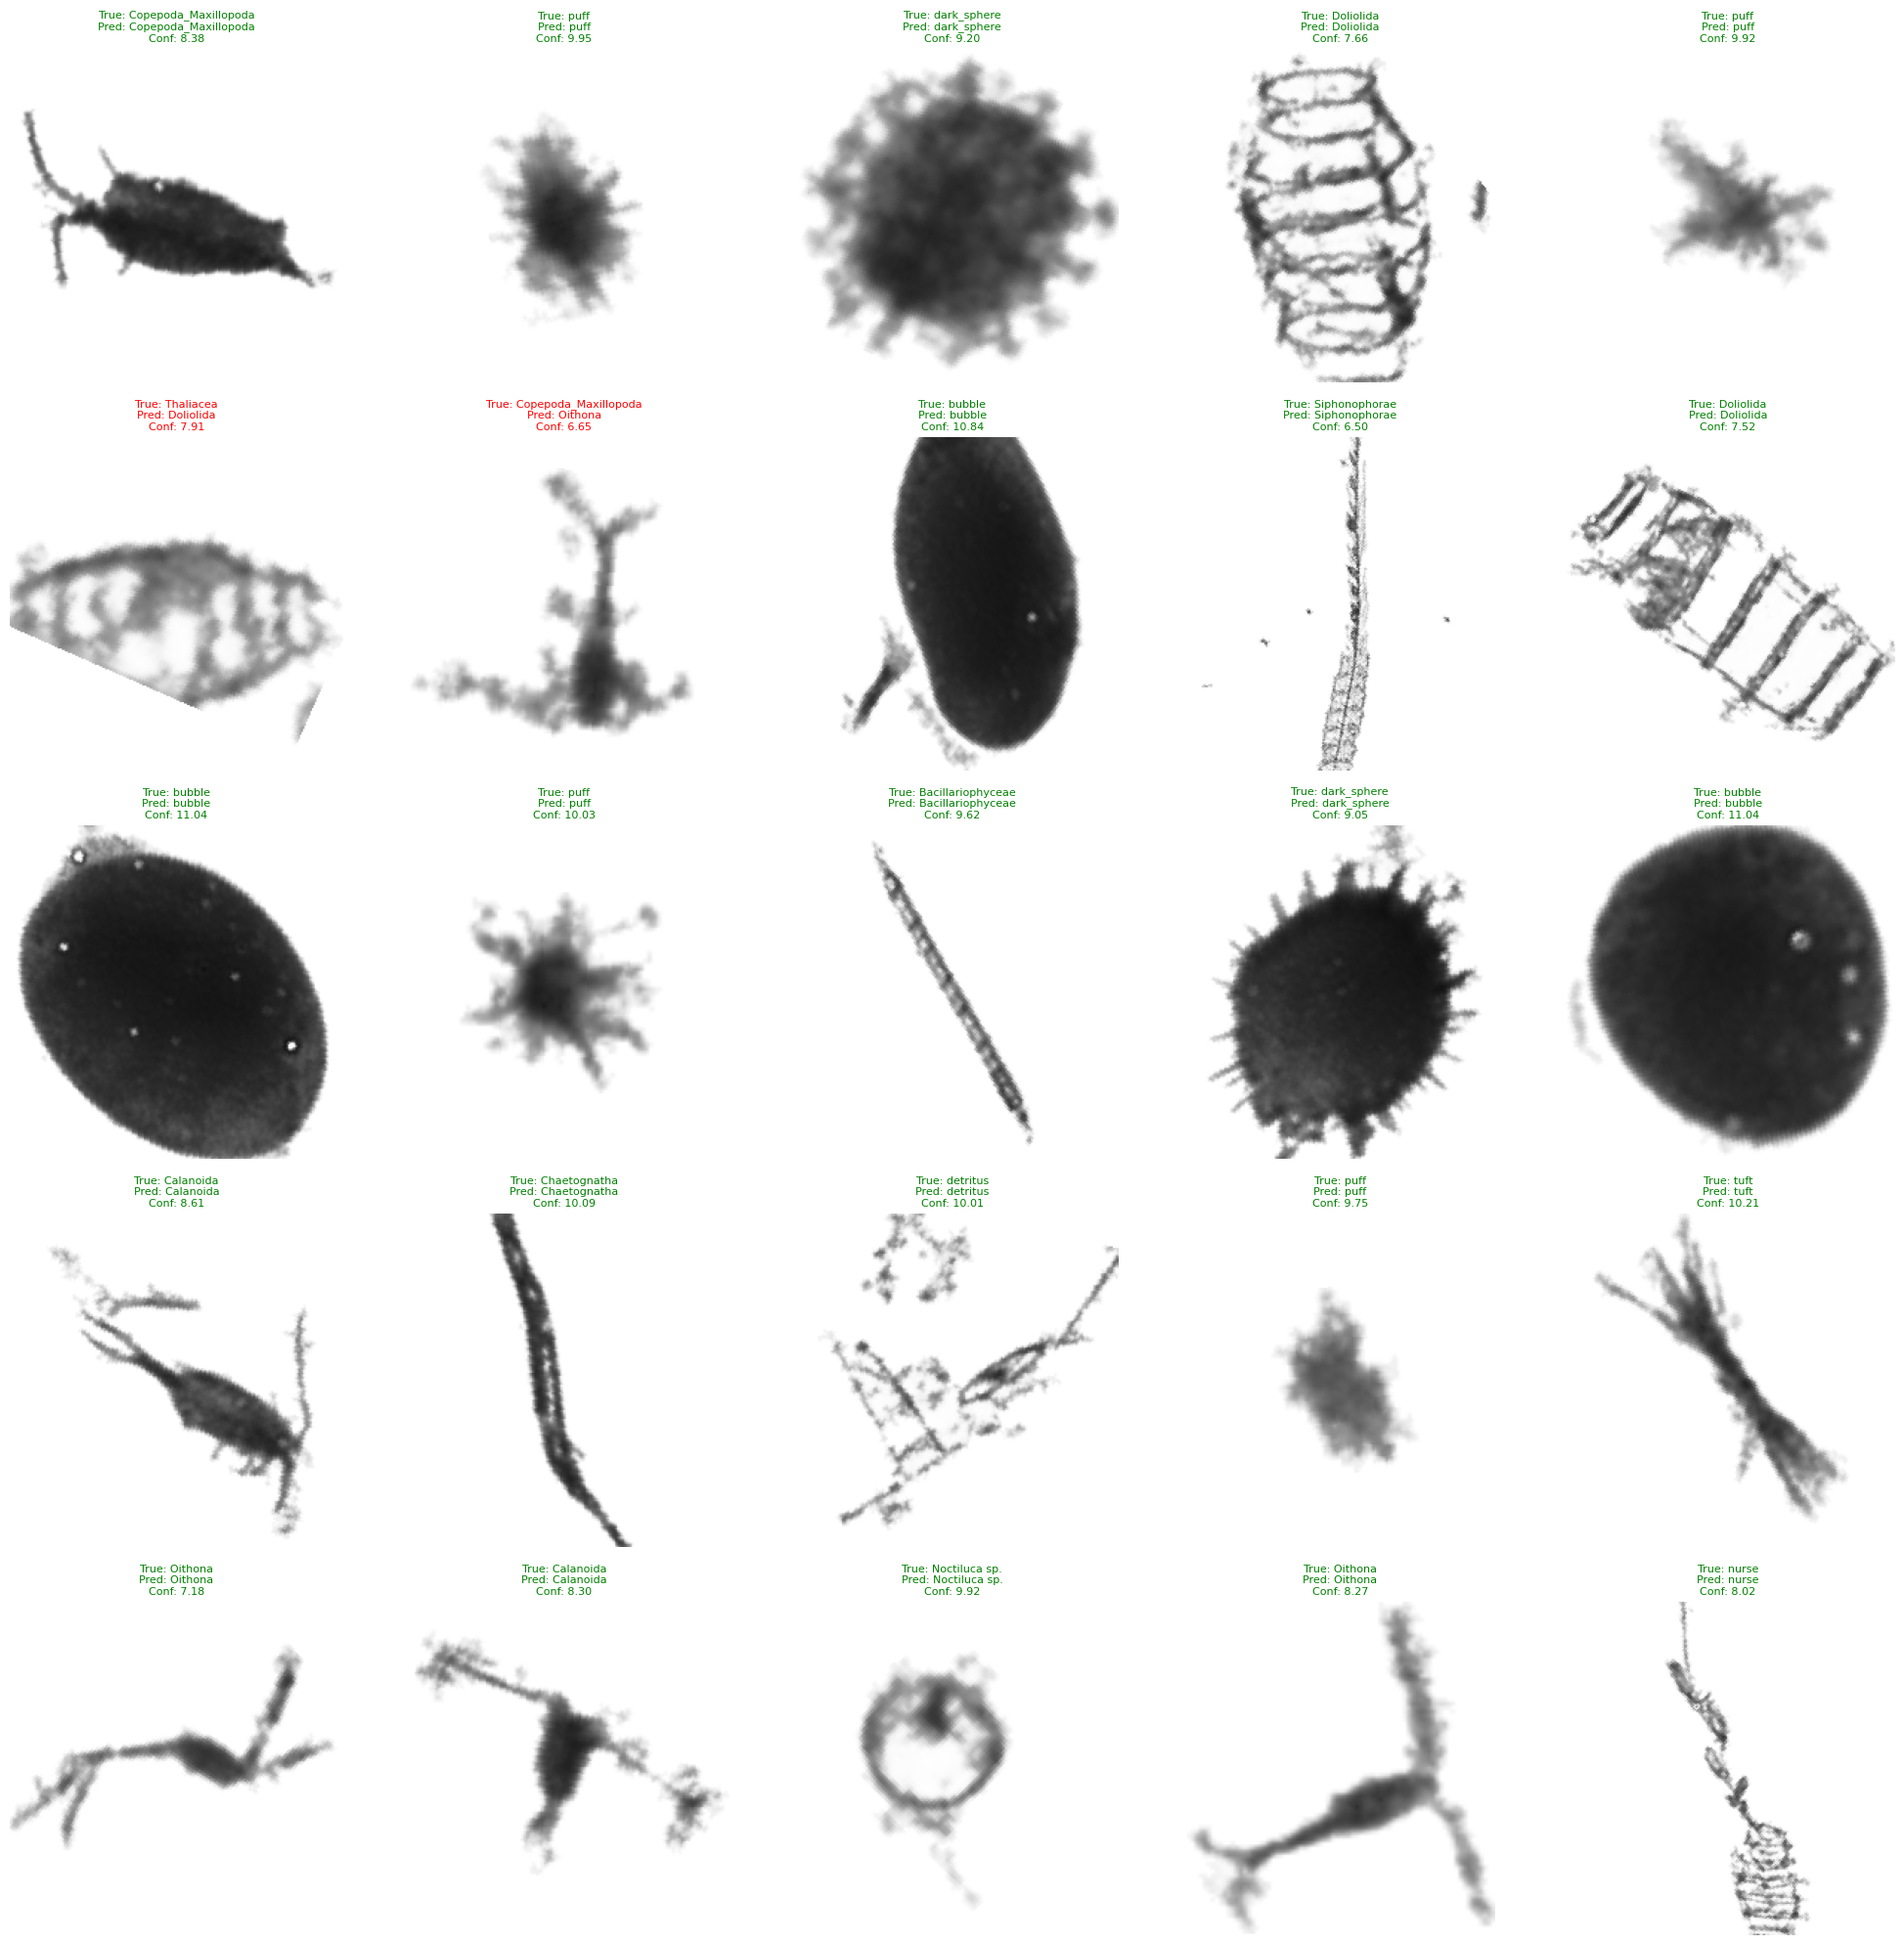


Overall Accuracy: 92.57%


In [51]:
def visualize_predictions(test_outputs, dataset, num_samples=25, rows=5, cols=5):
    """
    Visualize random samples with their true and predicted labels.
    
    Args:
        model: Trained ViT model
        dataset: Dataset with transformed images
        num_samples: Number of samples to visualize
        rows: Number of rows in the grid
        cols: Number of columns in the grid
    """
    # Get predictions for the whole dataset
    predictions = test_outputs.predictions.argmax(1)
    
    # Get random indices
    total_samples = len(dataset)
    random_indices = random.sample(range(total_samples), min(num_samples, total_samples))
    
    # Create a figure
    fig = plt.figure(figsize=(20, 20))
    
    # Get label names
    label_names = dataset.features['label'].names
    
    for idx, sample_idx in enumerate(random_indices):
        # Get original image and prediction
        sample = dataset[sample_idx]
        true_label = label_names[sample['label']]
        pred_label = label_names[predictions[sample_idx]]
        
        # Get confidence score
        confidence = test_outputs.predictions[sample_idx].max()
        
        # Create color for title based on correct/incorrect prediction
        title_color = 'green' if true_label == pred_label else 'red'
        
        # Plot the image
        plt.subplot(rows, cols, idx + 1)
        # Convert tensor to image for display
        img = sample['pixel_values'].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)  # Denormalize
        plt.imshow(img)
        
        # Add title with true and predicted labels
        title = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}'
        plt.title(title, color=title_color, fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Print overall accuracy
    accuracy = (predictions == test_outputs.label_ids).mean()
    print(f"\nOverall Accuracy: {accuracy:.2%}")

# Visualize predictions on the test set
visualize_predictions(test_outputs, test_ds, num_samples=25, rows=5, cols=5)

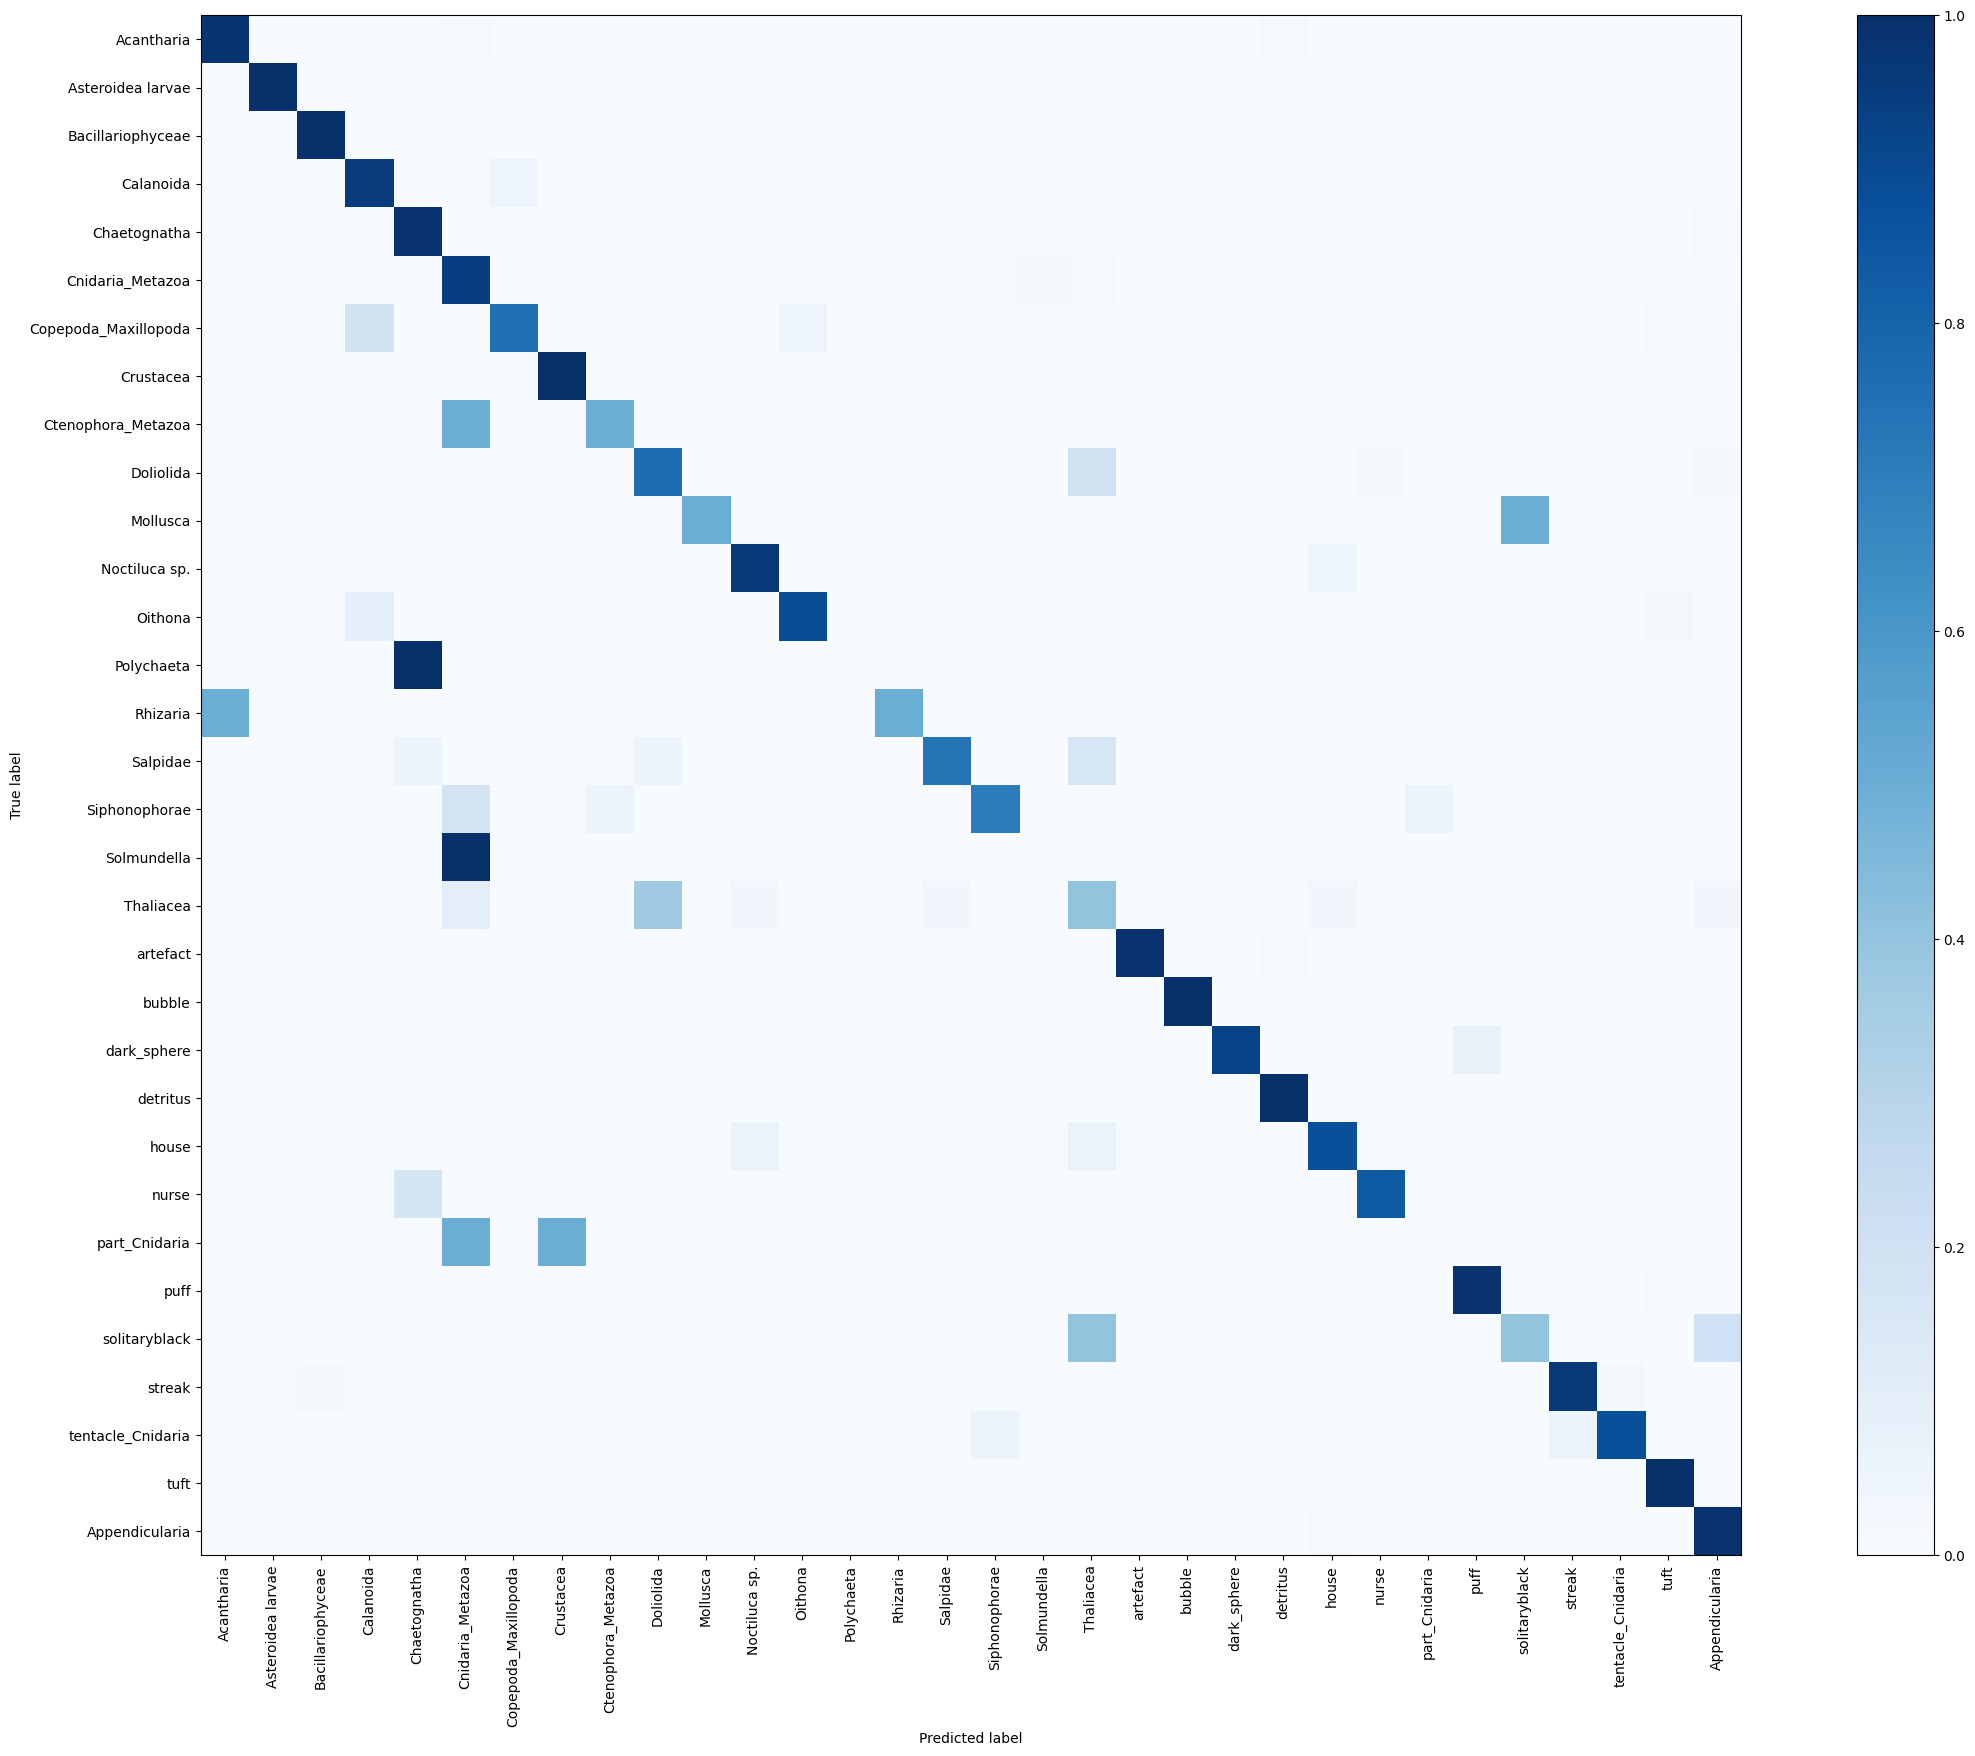

Recall for Acantharia: 0.98
Recall for Asteroidea larvae: 1.00
Recall for Bacillariophyceae: 1.00
Recall for Calanoida: 0.95
Recall for Chaetognatha: 0.99
Recall for Cnidaria_Metazoa: 0.94
Recall for Copepoda_Maxillopoda: 0.75
Recall for Crustacea: 1.00
Recall for Ctenophora_Metazoa: 0.50
Recall for Doliolida: 0.76
Recall for Mollusca: 0.50
Recall for Noctiluca sp.: 0.96
Recall for Oithona: 0.89
Recall for Polychaeta: 0.00
Recall for Rhizaria: 0.50
Recall for Salpidae: 0.74
Recall for Siphonophorae: 0.71
Recall for Solmundella: 0.00
Recall for Thaliacea: 0.40
Recall for artefact: 0.99
Recall for bubble: 1.00
Recall for dark_sphere: 0.93
Recall for detritus: 1.00
Recall for house: 0.88
Recall for nurse: 0.83
Recall for part_Cnidaria: 0.00
Recall for puff: 0.99
Recall for solitaryblack: 0.40
Recall for streak: 0.97
Recall for tentacle_Cnidaria: 0.88
Recall for tuft: 1.00
Recall for Appendicularia: 0.99


In [13]:
# Calculate and visualize confusion matrix

y_true = test_outputs.label_ids
y_pred = test_outputs.predictions.argmax(1)

labels = test_ds.features["label"].names
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a larger figure
fig, ax = plt.subplots(figsize=(30, 20))  # Create a figure and a set of subplots with specified size

# Define a colormap
cmap = plt.get_cmap('Blues')

# Create the confusion matrix display with normalized values
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=labels)

# Plot the confusion matrix
disp.plot(cmap=cmap, xticks_rotation='vertical', values_format='.2f', ax=ax)
# Remove the annotations
for text in disp.text_.ravel():
    text.set_visible(False)

# Show the plot
plt.show()

# Calculate recall for each class
recall = recall_score(y_true, y_pred, average=None)

# Print the recall for each class
for label, score in zip(labels, recall):
  print(f"Recall for {label}: {score:.2f}")

# Inference on test profile

In [ ]:
def load_unclassified_images(data_dir):
    # List all files in the directory and create full paths
    image_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
    
    # Prepare data for the dataset
    data = {
        'image': image_files,
        'label': image_files 
    }
    
    features = Features({
        'image': ImageFeature(),
        'label': Value('string')
    })
    
    # Create the dataset
    dataset = Dataset.from_dict(data, features=features)
    return dataset

# def get_predictions_on_dataset_in_batches(dataset, save_dir, batch_size=16):
#     print("Initializing model for predictions")
#     # Initialize model
#     vit = ViTForImageClassification.from_pretrained(save_dir)
    
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     vit.to(device)
    
#     predictions = []
#     filenames = []
#     probabilities = []
    
#     # Create a DataLoader for the dataset
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

#     # Iterate over the DataLoader to collect batches
#     for batch in tqdm(dataloader, desc="Processing dataset"):
#         # Move inputs to the device
#         inputs = batch['pixel_values'].to(device)

#         # Perform inference
#         with torch.no_grad():
#             outputs = vit(pixel_values=inputs)

#         # Convert logits to probabilities and get top-5 predictions
#         probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
#         top_probs, top_indices = torch.topk(probs, 5, dim=-1)
        
#         # Convert top-5 predictions to list of labels
#         top_labels = [
#             [vit.config.id2label[idx.item()] for idx in top_indices[i]]
#             for i in range(top_indices.size(0))
#         ]
        
#         # Collect top-5 predictions
#         predictions.extend(top_labels)
        
#         # Collect filenames
#         filenames.extend(batch['label'])

#         # Collect top-5 probabilities
#         probabilities.extend(top_probs.cpu().numpy())
    
#     print(f"Predictions completed for {len(filenames)} images")
#     return filenames, predictions, probabilities
def get_predictions_on_dataset_in_batches(dataset, save_dir, batch_size=64):
    print("Initializing model for predictions")
    vit = ViTForImageClassification.from_pretrained(save_dir)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vit.to(device)
    vit.eval()  # Ensure model is in eval mode
    
    # Optimize DataLoader
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,  # Parallel data loading
        pin_memory=True,  # Faster CPU to GPU transfer
        prefetch_factor=2  # Prefetch batches
    )
    
    predictions = []
    filenames = []
    probabilities = []
    
    with torch.amp.autocast('cuda'):  # Enable automatic mixed precision
        for batch in tqdm(dataloader, desc="Processing dataset"):
            # Batch processing in one go
            inputs = batch['pixel_values'].to(device, non_blocking=True)
            
            with torch.no_grad():
                outputs = vit(pixel_values=inputs)
            
            # Process predictions efficiently
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            top_probs, top_indices = torch.topk(probs, 5, dim=-1)
            
            # Batch process labels
            batch_labels = [[vit.config.id2label[idx.item()] for idx in indices] 
                          for indices in top_indices]
            
            predictions.extend(batch_labels)
            filenames.extend(batch['label'])
            probabilities.extend(top_probs.cpu().numpy())
    
    print(f"Predictions completed for {len(filenames)} images")
    return filenames, predictions, probabilities

In [37]:
img_dir = "/home/veit/Downloads/deconv_crops"  # Replace with your actual path to unclassified images
ds_pisco = load_unclassified_images(img_dir)

destination_path = '/home/veit/PIScO_dev/ViT_custom_size_sensitive/predictions'
os.makedirs(destination_path, exist_ok=True)

# Apply the transform to the dataset
ds_pisco_trans = ds_pisco.with_transform(process_batch)

# Define model name and path to the saved model
model_dir = '/home/veit/PIScO_dev/ViT_custom_size_sensitive/best_model'

# Get predictions on the dataset in batches
filenames, predictions, probabilities = get_predictions_on_dataset_in_batches(ds_pisco_trans, model_dir, batch_size=64)

# Create a DataFrame and store it on disk
df = pd.DataFrame({
    'filename': filenames,
    'top1': [pred[0] for pred in predictions],
    'top2': [pred[1] for pred in predictions],
    'top3': [pred[2] for pred in predictions],
    'top4': [pred[3] for pred in predictions],
    'top5': [pred[4] for pred in predictions],
    'prob1': [prob[0] for prob in probabilities],
    'prob2': [prob[1] for prob in probabilities],
    'prob3': [prob[2] for prob in probabilities],
    'prob4': [prob[3] for prob in probabilities],
    'prob5': [prob[4] for prob in probabilities]
})    
result_path = os.path.join(destination_path, 'ViT_predictions.csv')
df.to_csv(result_path, index=False)
print("Predictions saved!")

# Print the first 5 predictions
print(df.head())

Initializing model for predictions


/tmp/ipykernel_344617/277697626.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable automatic mixed precision
Processing dataset: 100%|██████████| 657/657 [00:46<00:00, 14.08it/s]


Predictions completed for 41989 images
Predictions saved!
                                            filename                  top1  \
0  /home/veit/Downloads/deconv_crops/20220511-003...                  tuft   
1  /home/veit/Downloads/deconv_crops/20220511-003...  Copepoda_Maxillopoda   
2  /home/veit/Downloads/deconv_crops/20220511-003...                  tuft   
3  /home/veit/Downloads/deconv_crops/20220511-004...                streak   
4  /home/veit/Downloads/deconv_crops/20220511-003...                  tuft   

                top2               top3               top4      top5  \
0       Chaetognatha  Bacillariophyceae               puff   Oithona   
1      Noctiluca sp.     Appendicularia           artefact      puff   
2             streak       Chaetognatha  Bacillariophyceae      puff   
3  tentacle_Cnidaria  Bacillariophyceae           artefact  detritus   
4       Chaetognatha               puff            Oithona    streak   

      prob1     prob2     prob3     prob

In [48]:
print(df['filename'][2])


/home/veit/Downloads/deconv_crops/20220511-00343762_002.272bar_28.47C_204.png



Visualizing random samples with predictions:


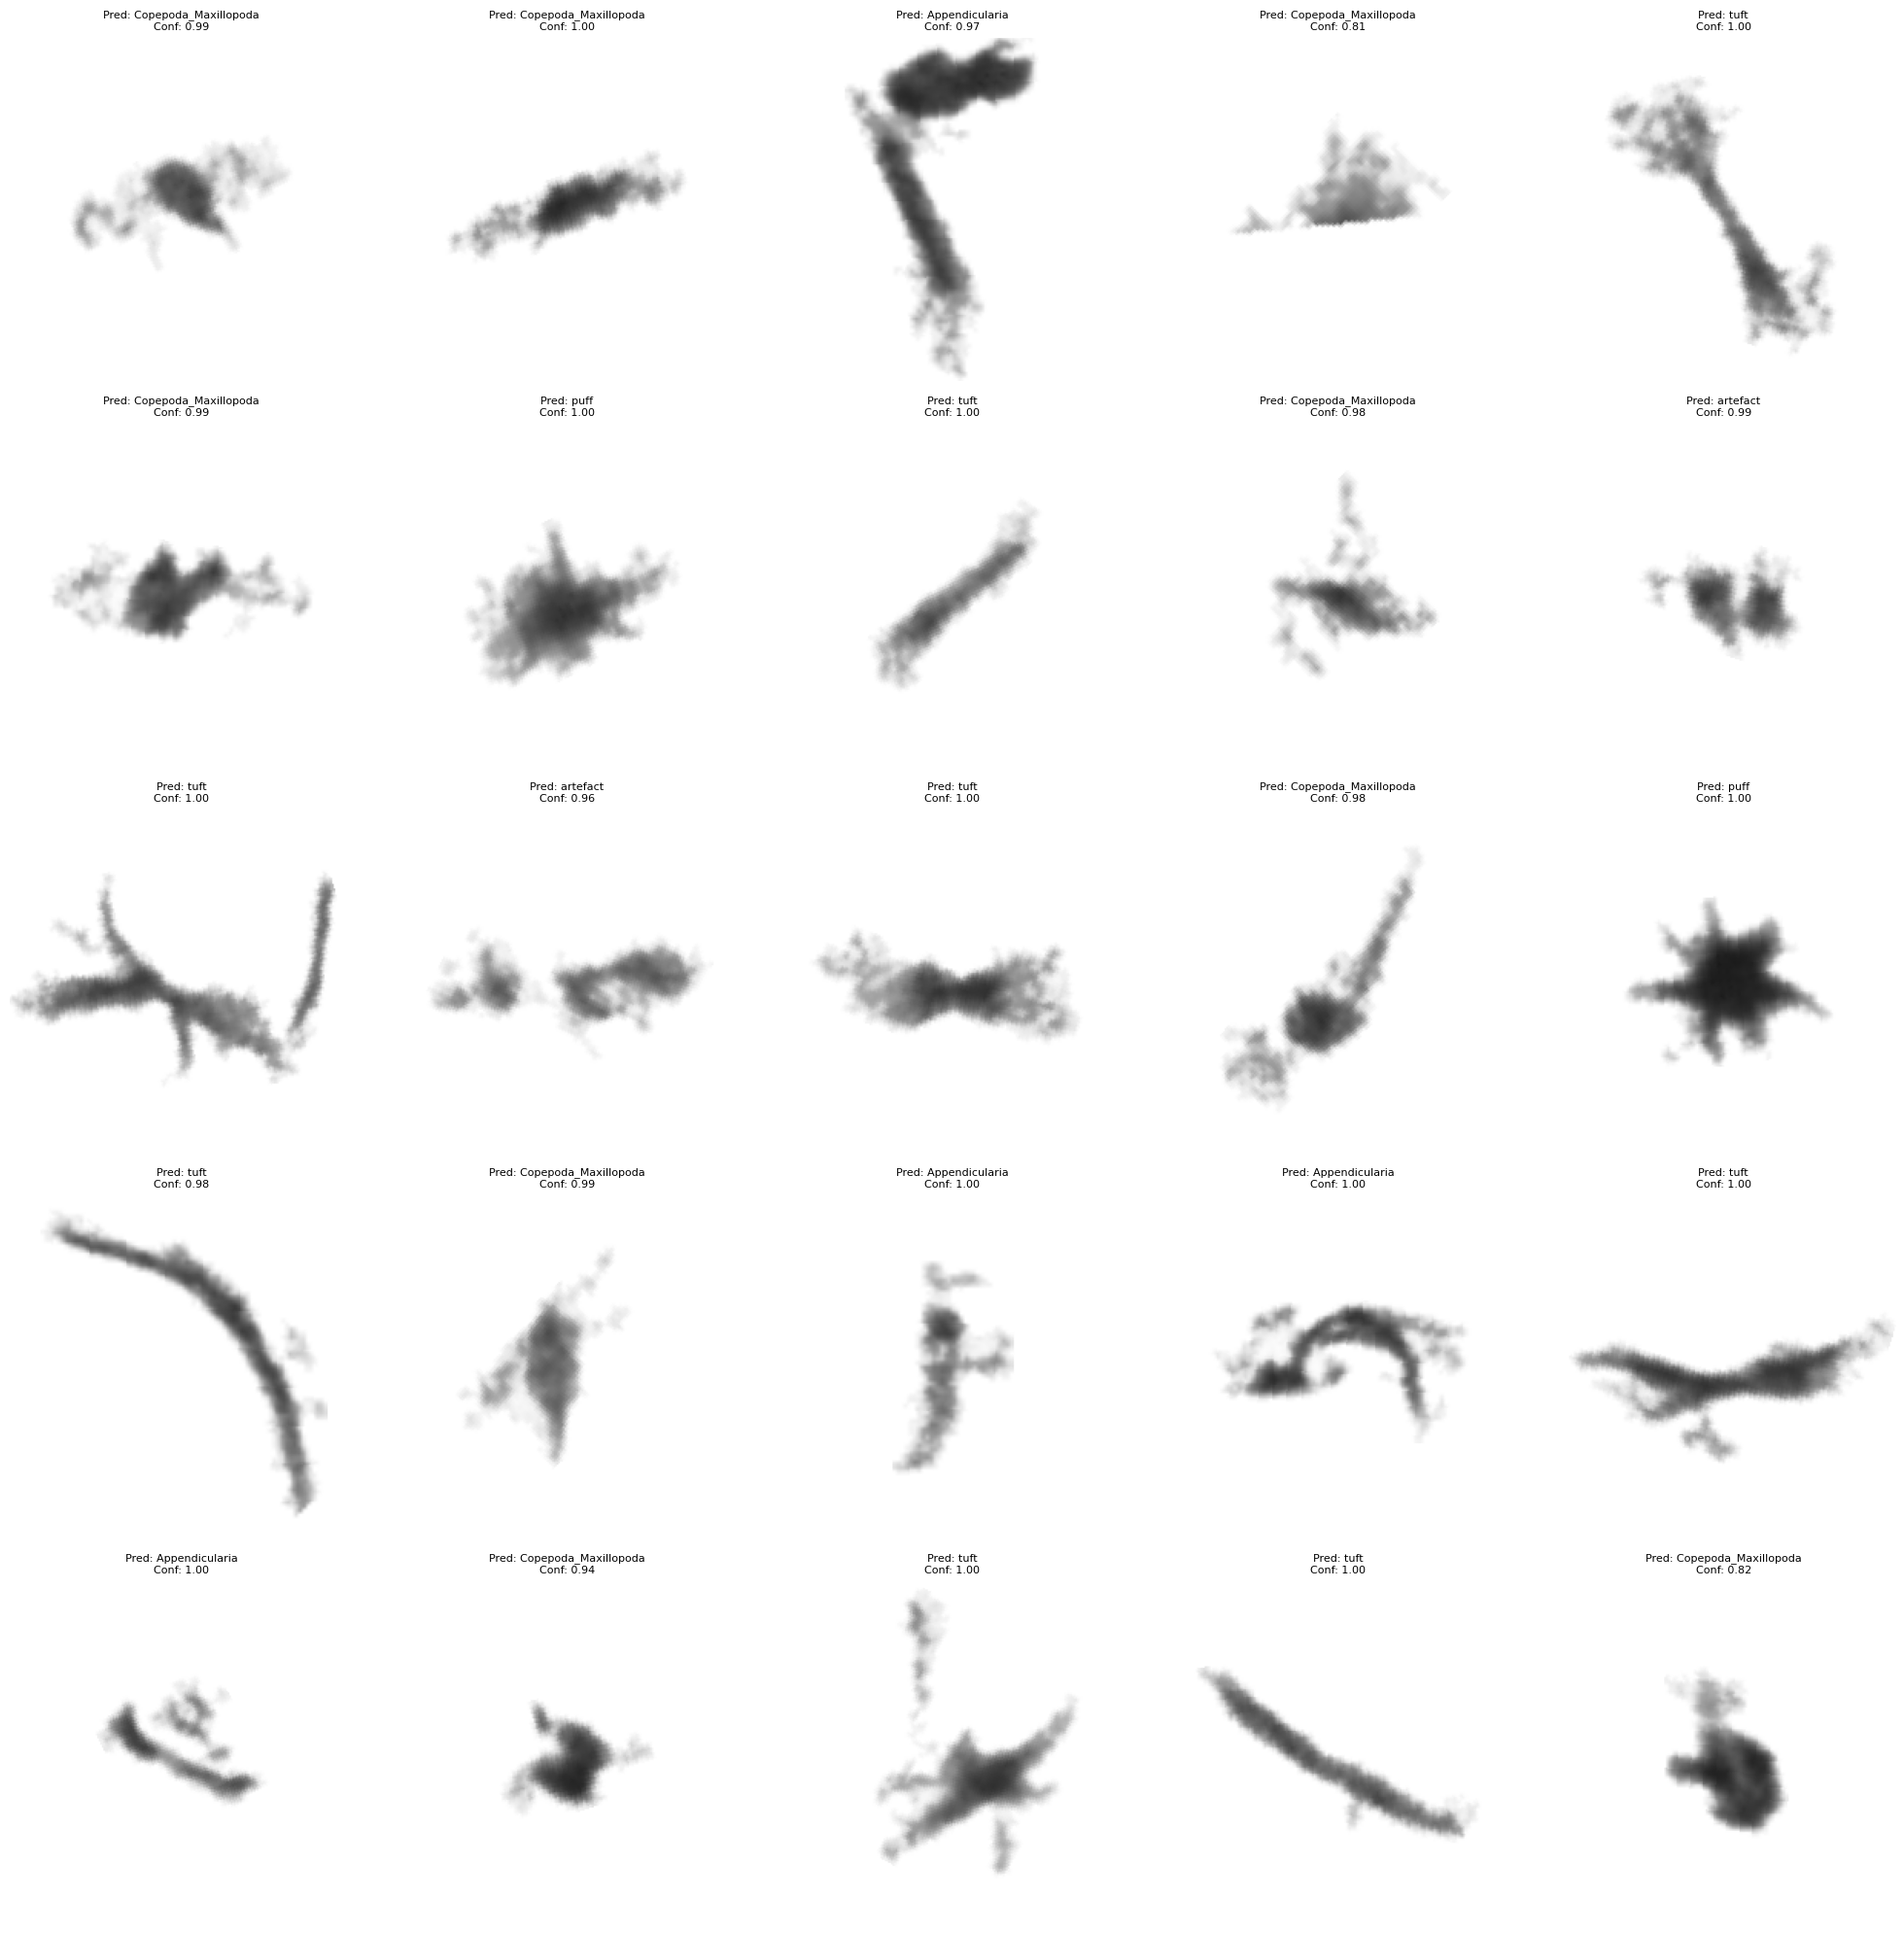

In [50]:
def visualize_inference(dataset, predictions, probabilities, num_samples=25, rows=5, cols=5):
    """
    Visualize random samples with their predicted labels and confidence scores.
    """
    # Get random indices
    total_samples = len(dataset)
    random_indices = random.sample(range(total_samples), min(num_samples, total_samples))
    
    # Create a figure
    fig = plt.figure(figsize=(20, 20))
    
    for idx, sample_idx in enumerate(random_indices):
        # Get image and prediction
        sample = dataset[sample_idx]
        pred_label = predictions[sample_idx][0]  # Top prediction
        confidence = probabilities[sample_idx][0]  # Top confidence
        
        # Plot the image
        plt.subplot(rows, cols, idx + 1)
        # Convert tensor to image for display
        img = sample['pixel_values'].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)  # Denormalize
        plt.imshow(img)
        
        # Add title with predicted label and confidence
        title = f'Pred: {pred_label}\nConf: {confidence:.2f}'
        plt.title(title, fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Add this after the DataFrame creation:
print("\nVisualizing random samples with predictions:")
visualize_inference(ds_pisco_trans, predictions, probabilities)